In [1]:
import pandas as pd
import re
import datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from datetime import date
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import PoissonRegressor

In [2]:
def read_files(parquet_file, csv_file, xlsx_file):
    '''
    Reading data from different file paths and some pre-processing
    
    Parameters:
    -----------------------------
        parquet_file: str, path to the parquet file
        csv_file: str, path to the csv file
        xlsx_file: str, path to the xlsx file
        
    Returns:
    -----------------------------
        a dataframe that contains the final data to be fed to the model
    '''
    
    # Reading the parquet file
    claims = pd.read_parquet(parquet_file)
    
    # Reading the excel file
    policies = pd.read_excel(xlsx_file, engine = "openpyxl")
    
    # Reading the csv file
    properties = pd.read_csv(csv_file)
    
    # Call to date process function to process the date column
    claims_clean = date_process(claims, "start_date")
    policies_start_clean = date_process(policies, "start")
    policies_clean = date_process(policies_start_clean, "end")
    
    # Call to data process function to join dataframes and produce final result
    final_data = data_process(claims_clean, policies_clean, properties)
    
    return final_data

In [3]:
def date_process(df, column):
    '''
    Process the date column and convert it into a datetime object
    
    Parameters:
    -----------------------------
        df: dataframe, the dataframe that contains columns to be processed
        column: str, column to be processed
        
    Returns:
    -----------------------------
        a dataframe with the specified columns processed
    '''
    
    # Regex to extract day, month and year into separate dataframe from the date column
    df1 = df[column].str.extract('(?P<day>\d+)(?P<month>[A-Za-z]{3})(?P<year>.*)')
    
    # Remove any special characters present in the year column
    df1['year'].replace(regex=True, inplace=True, to_replace=r'[^0-9]', value=r'')
    
    # Join the original dataframe with the dataframe containing day, month and year
    df2 = pd.concat([df, df1], axis=1)
    
    # Drop the raw date column
    df2.drop(column, axis = 1, inplace = True)
    
    # Combining the day, month and year into a datetime object and dropping the columns
    df2[column] = pd.to_datetime(df2['year'].astype(str)  + df2['month'] + df2['day'].astype(str), format='%Y%b%d', errors = 'coerce')
    df2.drop(['day', 'month', 'year'], axis = 1, inplace = True)
    
    return df2

In [4]:
def data_process(claims, policies, properties):
    
    '''
    Reading data from different dataframes and some pre-processing
    
    Parameters:
    -----------------------------
        claims: dataframe, the dataframe that contains claims data
        policies: dataframe, the dataframe that contains policies data
        properties: dataframe, the dataframe that contains properties data
        
    Returns:
    -----------------------------
        a dataframe with the specified columns processed
    '''
    
    # Removing the NA values. It's very few values (5-10)
    claims.dropna(inplace = True)
    policies.dropna(inplace = True)
    
    # Calculate the policy duration and convert it into years
    policies['duration'] = policies['end'] - policies['start']
    policies['duration'] = (policies['duration']/ datetime.timedelta(days = 365)).astype(int)
    
    # Group claims to get the number of claims associated with each property and policy
    claims_grouped = claims.groupby(['property', 'pol', 'start_date']).count().reset_index()
    
    # Merge the grouped claims dataset and properties to obtain the attributes of the property.
    interim_result = pd.merge(claims_grouped, properties, left_on = "property", right_on = "prop_id", how = "inner")
    
    # Drop some columns and rename a few other
    interim_result.drop(['pol_x', 'property'], inplace = True, axis = 1)
    interim_result.rename(columns = {'pol_y': 'pol', 'amount': 'claims'}, inplace = True)
    
    # merge the resultant dataframe with the policies to obtain the term of each policy
    result = pd.merge(interim_result, policies, left_on = ['pol', 'start_date'], right_on = ['pol', 'start'], how = "inner")
    
    # Drop unwanted columns
    result.drop(['end', 'start', 'prop_id', 'start_date', 'pol'], inplace = True, axis = 1)
    
    # Calculate exposure and claims_frequency
    result['exposure'] = (result['sqft']/1000) * result['duration']
    result['claim_frequency'] = result['claims']/result['exposure']
    
    return result

In [5]:
result_final = read_files("claims.parquet", "properties.csv", "policies.xlsx")

In [6]:
def model_train(result_final):
    
    '''
    Training the final model
    
    Parameters:
    -----------------------------
        result_final: dataframe, the dataframe to be fed to the model
        
    Returns:
    -----------------------------
        the final trained model
    '''
    
    # Split dataset into regressors and target
    X_train = result_final.drop(columns = ['claim_frequency'])
    y_train = result_final['claim_frequency']
    
    # Define preprocessing steps required
    # Scale the numeric variables 
    numeric_transformer = Pipeline(
    steps = [
        ("scaler", StandardScaler())
        ]
    )
    
    # Transform the categorical variables using One-hot encoding
    categorical_transformer = Pipeline(
        steps=[
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )
    
    # Defining a Column Transformer to combine the numeric and categorical variables pre-processing
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, ['sqft', 'age', 'exposure', 'claims']),
            ("cat", categorical_transformer, ['state']),
        ]
    )

    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", PoissonRegressor(alpha = 1e-3, max_iter=300))
        ]
    ).fit(X_train, y_train, regressor__sample_weight = X_train['claims'])
    
    return pipe
    

In [7]:
model = model_train(result_final)

## The below part describes the model selection process. The train function only has the final selected model

In [10]:
df_train, df_test = train_test_split(result_final, test_size=0.2, random_state=0)
    
X_train = df_train.drop(columns = ['claim_frequency'])
y_train = df_train['claim_frequency']

X_test = df_test.drop(columns = ['claim_frequency'])
y_test = df_test['claim_frequency']

### My initial instinct was to try a linear regression model. So I decided to try the Linear model with regularization. On training I realised that negative values were a possibility and that was not desirable in this scenario. 

In [509]:
from sklearn.linear_model import Ridge

pd.DataFrame(cross_validate(
    pipe, X_train, y_train, return_train_score=True, 
    scoring=["neg_mean_absolute_error"]
))


,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error
0,0.026948,0.021511,-0.108987,-0.118300
1,0.028242,0.009153,-0.120165,-0.111731
2,0.022598,0.008371,-0.114362,-0.116266
3,0.023083,0.008475,-0.115167,-0.116023
4,0.022605,0.008435,-0.116796,-0.112906


In [581]:
preprocessor.fit(X_train)
X_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

#### Then I went through the GLM family of models. Gamma seemed to be the best fit because it had a range of 0 to inf. The reasoning being that claims_frequency could be 0 o greater and is a continuous variable. Most of the other models seemed to have a discrete range and this was not on par with the expected output

In [583]:
import statsmodels.api as sm

gamma_model = sm.GLM(y_train, X_transformed, family=sm.families.Gamma())
gamma_results = gamma_model.fit()

gr = gamma_results.predict(X_test_transformed)

/opt/miniconda3/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [531]:
pipe_1.predict(X_test)

array([0.14210745, 0.03227437, 0.19305008, ..., 0.24241986, 0.22168222,
       0.08315073])

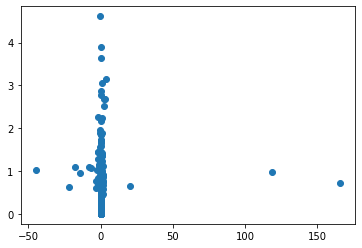

In [584]:
plt.scatter(gr, y_test)

#### But the results were bad. So, I decided to try the Poisson Regression class which ouput a continuous range and I also had the option to place extra weight on the number of claims and decide the claim frequency. That is the model that is finally a part of the model training function. Also, I decided against using a ZIF model because when joining the tables, i seemed to have an issue joining the 3 and most of the properties without claims was excluded.